# Live Sign Language Translator
Our goal is to create a program that will recognise sign language caught by video and translate it into it's English counterpart.
####Current Limitations:
- Only recognises ASL Letters and not any words.
- Dataset does not include J and Z since they require motion. Current workaround is to put a placeholder and try to guess the word while generating words

In [2]:
import numpy as np 
import pandas as pd # data processing
import os, sys
import time
import matplotlib.pyplot as plt

import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

#### Presetup before generating and training NN

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#set device so that the model and data will run on the correct graphics device
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(dev)

cuda


In [5]:
class Net(nn.Module):
    def __init__(self):
        ''' init the nerual network '''
        super(Net, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.BatchNorm2d(8),
            nn.AvgPool2d(2),
            nn.ReLU()
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 16, 3),
            nn.BatchNorm2d(16),
            nn.AvgPool2d(2),
            nn.ReLU()
        )
        
        self.fc1 = nn.Linear(16*5*5, 100)
        self.fc2 = nn.Linear(100, 64)
        self.leak = nn.LeakyReLU()
        self.drop = nn.Dropout(p=0.3)
        self.fc3 = nn.Linear(64, 25)
        

    def forward(self, x):
        '''defines the forward prop algorithm'''
        #apply Convolution on the relu'd results from the convolution layers
        x = self.layer1(x)
        x = self.layer2(x)

        x = x.view((x.shape[0], -1))

        #run the fcs
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.leak(x)
        x = self.drop(x)

        #fc4 will give us the final **24** layers
        x = self.fc3(x)

        return x

net = Net()
#switch the nn to run on gpu if available
net = net.to(dev)
print(net)

Net(
  (layer1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): ReLU()
  )
  (fc1): Linear(in_features=400, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=64, bias=True)
  (leak): LeakyReLU(negative_slope=0.01)
  (drop): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=25, bias=True)
)


####Define the Loss Function and Optimizer

In [6]:
crit = nn.CrossEntropyLoss()
#feel free to play around with the lr(learning rate) and momentum
optimizer = optim.Adam(net.parameters(), lr=0.001)

#### Set up Training Data
Init and transform data before running it through nn

In [7]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Colab Notebooks/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/Colab Notebooks/kaggle/input/amer_sign2.png
/content/drive/MyDrive/Colab Notebooks/kaggle/input/american_sign_language.PNG
/content/drive/MyDrive/Colab Notebooks/kaggle/input/amer_sign3.png
/content/drive/MyDrive/Colab Notebooks/kaggle/input/sign_mnist_test.csv
/content/drive/MyDrive/Colab Notebooks/kaggle/input/sign_mnist_train.csv
/content/drive/MyDrive/Colab Notebooks/kaggle/input/sign_mnist_test/sign_mnist_test.csv
/content/drive/MyDrive/Colab Notebooks/kaggle/input/sign_mnist_train/sign_mnist_train.csv


In [8]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle/input/sign_mnist_train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle/input/sign_mnist_test.csv')
#Put in J as a _ to maintain 1to1 matching in nn
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', '_', 'K', 'L', 'M', 
          'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']

Create Class for Dataset to init and transform datasets
I'm setting up the data similar to how Georgy Popov did in his nn on kaggle
https://www.kaggle.com/code/wacholder000/simple-convolution-nn-in-pytorch-test-acc-95

In [9]:
class SignLanguageDataset(data.Dataset):

    def __init__(self, df, transform=None):
        '''init dataset'''
        self.df = df
        self.transform = transform

    def __len__(self):
        '''init return length of dataset'''
        return self.df.shape[0]

    def __getitem__(self, index):
        '''define label and transform image based on index given'''
        label = self.df.iloc[index, 0]

        img = self.df.iloc[index, 1:].values.reshape(28, 28)
        img = torch.Tensor(img).unsqueeze(0)
        
        if self.transform is not None:
            img = self.transform(img)

        return img, label

In [10]:
#method for showing images using mathplt
def show_img(img, label):
    img = img.squeeze()
    img = img*40. + 159.
    imgnp = img.detach().numpy()
    plt.imshow(img, interpolation='bicubic')
    print(label)

In [19]:
train_transform = transforms.Compose([
    #randomly flip/rotate images to better train nn
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomApply([transforms.RandomRotation(degrees=(-180,180))],
                           p = 0.2)
])

In [20]:
train_dataset = SignLanguageDataset(train, transform=train_transform)
test_dataset = SignLanguageDataset(test)

In [21]:
train_loader = data.DataLoader(train_dataset, batch_size=200, shuffle=True,
                               num_workers=2)
test_loader = data.DataLoader(test_dataset, batch_size=200, shuffle=True,
                              num_workers=2)

In [22]:
trainiter = iter(train_loader)
img, label = next(trainiter)
print(img.shape)

torch.Size([200, 1, 28, 28])


tensor(24)


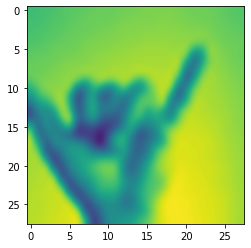

In [23]:
show_img(img[10], label[10])

#### Define Training and Eval
Now that we have defined a simple conv2d nn and init all our training data, we can start work on defining our training and evaluation algorithms

In [24]:
def eval_net(model, crit, test_loader):

    #this will switch the net to run on gpu if supported and selected
    #if there is no device chosen, default will be cpu
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    model = model.to(device)

    model = model.eval()

    running_loss = 0.0
    num_correct = 0.0
    num_total = 0.0

    for batch, labels in test_loader:

        batch = batch.to(device)
        labels = labels.to(device)

        out = model(batch)
        pred_labels = out.argmax(dim=1)
        num_correct += float((pred_labels == labels).sum())

        loss = crit(out, labels)
        running_loss += loss.data.cpu()

        num_total += labels.shape[0]

    mean_loss = running_loss / num_total
    accuracy = num_correct / num_total

    return mean_loss, accuracy

In [25]:
def train_model(n_epochs, model, optimizer, crit, train_loader,
                test_loader):
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)
    
    model = model.train()
    
    train_loss, train_acc = [], []
    test_loss, test_acc = [], []
    
    for epoch in range(n_epochs):
        
        t0 = time.perf_counter()
        
        running_loss = 0.
        num_correct = 0.
        num_total = 0.
        
        for batch, labels in train_loader:
            batch = batch.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            
            out = model(batch)
            
            pred_labels = out.argmax(dim=1)
            num_correct += float((pred_labels == labels).sum())
            num_total += labels.shape[0]
            
            loss = crit(out, labels)
            running_loss += loss
            loss.backward()
            optimizer.step()
        
        epoch_loss = running_loss / num_total
        epoch_acc = num_correct / num_total
        
        train_loss.append(epoch_loss.data.cpu())
        train_acc.append(epoch_acc)
        
        t_loss, t_acc = eval_net(model, crit, test_loader)
        
        test_loss.append(t_loss.data.cpu())
        test_acc.append(t_acc)
        
        t1 = time.perf_counter()
        
        delta_t = t1 - t0
        print(f"EPOCH {epoch+1} ({round(delta_t, 4)} s.): train loss - {epoch_loss}, train accuracy - {epoch_acc}; test loss - {t_loss}, test accuracy - {t_acc}")
    
    
    return model, train_loss, train_acc, test_loss, test_acc        
        

#### Run the train_model func

In [26]:
net, train_loss, train_acc, test_loss, test_acc = train_model(20, net, optimizer, crit,
                                                     train_loader, test_loader)


EPOCH 1 (12.0428 s.): train loss - 0.0069839833304286, train accuracy - 0.6196321252959388; test loss - 0.002906292676925659, test accuracy - 0.8243167875069716
EPOCH 2 (12.0198 s.): train loss - 0.0041126832365989685, train accuracy - 0.7547259151338555; test loss - 0.0024697131011635065, test accuracy - 0.8478806469604016
EPOCH 3 (12.0147 s.): train loss - 0.0027436232194304466, train accuracy - 0.8356947732653432; test loss - 0.0030446609016507864, test accuracy - 0.8229224762967094
EPOCH 4 (12.2116 s.): train loss - 0.0025573554448783398, train accuracy - 0.8437443088690585; test loss - 0.002404527273029089, test accuracy - 0.8601505856107083
EPOCH 5 (13.0763 s.): train loss - 0.002108034212142229, train accuracy - 0.8684392642505919; test loss - 0.002236147178336978, test accuracy - 0.8753485778025656
EPOCH 6 (12.0984 s.): train loss - 0.0019711926579475403, train accuracy - 0.8768530322345657; test loss - 0.002386507811024785, test accuracy - 0.8683770217512549
EPOCH 7 (12.0279 s

Accuracy: 0.914, 0.877


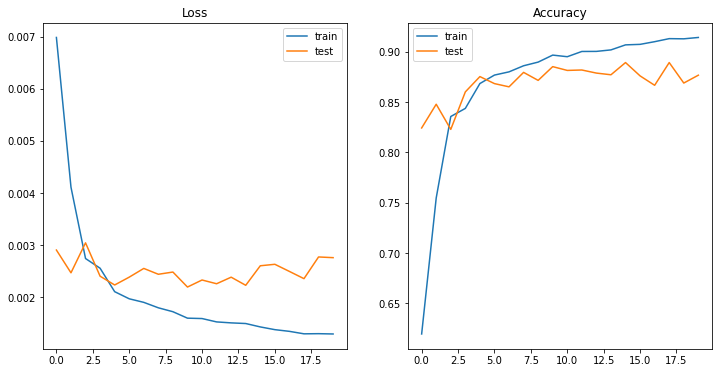

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.plot(train_loss)
ax1.plot(test_loss)
ax1.legend(['train', 'test'])
ax1.set_title('Loss')
ax2.plot(train_acc)
ax2.plot(test_acc)
ax2.legend(['train', 'test'])
ax2.set_title('Accuracy')

print("Accuracy: %.3f, %.3f" % (train_acc[19], test_acc[19]))

#### Save Model

In [28]:
state = net.state_dict()

torch.save(state, './sign_lang_net.pth')

#### Check Model



In [35]:
testiter = iter(test_loader)
img, label = next(testiter)
net = net.cpu()

X: 99.99%
T: 0.00%
D: 0.00%
I: 0.00%
Q: 0.00%
Correct: X
tensor(23)


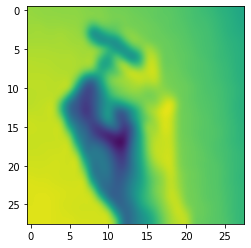

In [36]:
image = img[0]
lab = label[0]

batch = train_transform(image).unsqueeze(0)
# if you want to run a single img through the nn do this
pred = net(batch).squeeze(0).softmax(0)
class_id = pred.argmax().item()
#class_id will give the most likely index.
#Ex: if class_id is 7 -> that means the expected value would be labels[7] or H

_, indicies = torch.sort(pred, descending=True)
    
for ind in indicies[:5]:
    i = ind.item()
    print(f"{labels[i]}: {100.*pred[i]:.2f}%")

print(f"Correct: {labels[lab]}")

show_img(batch, lab)

# New Section